In [1]:
import pandas as pd 
import numpy as np 


In [2]:
X = pd.read_csv('../data/Train_cg.csv', low_memory=False)
y = pd.read_csv('../data/Test_cg.csv', low_memory=False)

In [3]:
X.head()

,ModelID,datasource,YearMade,MachineHoursCurrentMeter,UsageBand,fiBaseModel,fiSecondaryDesc,ProductSize,state,Drive_System,...,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,Vehicle_Type,Power_Rating,Horsepower,Horsepower_Type
0,3157,121,2004.0,68.0,1,295,36,6,1,4,...,3,0,0,6,3,1,5,8,120.0,1
1,77,121,1996.0,4640.0,1,526,50,3,27,4,...,3,0,0,6,3,1,5,20,175.0,1
2,7009,121,2001.0,2838.0,0,109,151,6,34,4,...,3,0,0,6,4,4,2,15,-10000.0,1
3,332,121,2001.0,3486.0,0,1374,151,5,45,4,...,3,0,0,6,4,4,3,9,-10000.0,1
4,17311,121,2007.0,722.0,2,1528,151,6,34,4,...,3,0,0,6,4,4,2,25,-10000.0,1


In [4]:
y.head()

,SalePrice
0,66000
1,57000
2,10000
3,38500
4,11000


In [5]:
y.shape[0] == X.shape[0]

True

In [9]:
df = pd.merge(X,y, on=X.index)

From the Gradient Boosted Model, we found the most important features are 'ProductSize', 'YearMade', 'Horsepower'. So let's build a linear model that looks at the predictive power of these features.

We'll use a Bayesian approach, so we can better taken into account the range of values a given piece of equipment may sell for, at the auction.

To get a feel for the numpyro probabilistic programing language (ppl), I'm following the Bayesian Regression tutorial, which can be found [here.](https://num.pyro.ai/en/latest/tutorials/bayesian_regression.html)

In [10]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

assert numpyro.__version__.startswith('0.4.1')

Let's check for nulls in our key variables. And filter out rows that have unreliable data for these points.

In [24]:
df[['ProductSize', 'YearMade','Horsepower','SalePrice']].isna().sum(axis=1)

0         0
1         0
2         4
3         4
4         4
         ..
401120    4
401121    4
401122    4
401123    4
401124    4
Length: 401125, dtype: int64

In [32]:
df = df.where(X['Horsepower'] > 0)
df = df.where(X['YearMade'] > 0 )


In [42]:
df = df[df['Horsepower'].notnull()]
df = df[df['YearMade'].notnull()]
df = df[df['ProductSize'].notnull()]

Let's explore these variables closer, looking at the pair-wise relaitonship, using the seaborn plotting library.

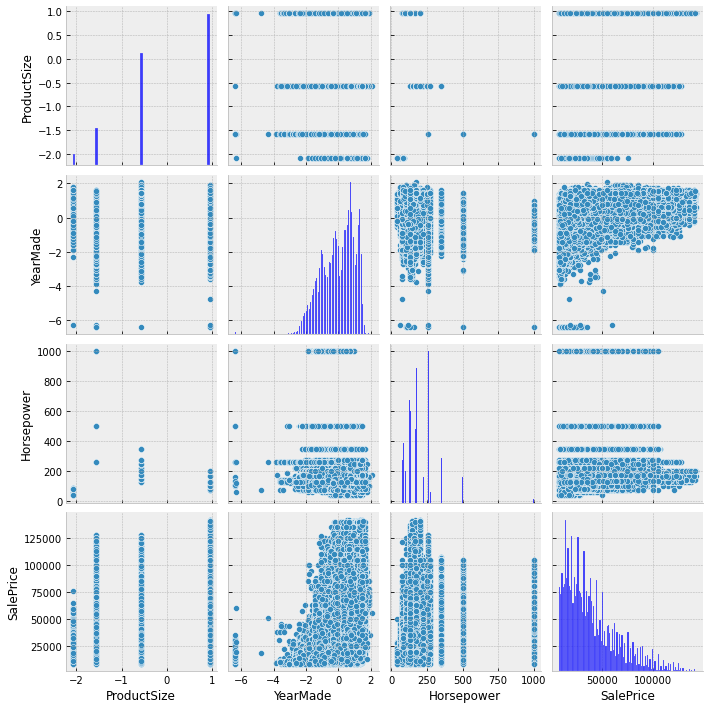

In [43]:
feats = ['ProductSize', 'YearMade','Horsepower', 'SalePrice']
sns.pairplot(df, x_vars=feats, y_vars=feats, palette='husl')

/home/feli/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='YearMade', ylabel='SalePrice'>

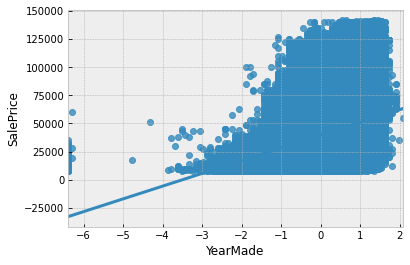

In [45]:
sns.regplot('YearMade', 'SalePrice', df)

Let's standardize our data to for faster and more accurate inference.

In [58]:
standardize = lambda x: (x - x.mean()) / x.std()

df['ProductSize'] = df['ProductSize'].pipe(standardize)
df['YearMade'] = df['YearMade'].pipe(standardize)
df['Horsepower'] = df['Horsepower'].pipe(standardize)
df['SalePrice'] = df['SalePrice'].pipe(standardize)

Now we write our predictive model in numpyro. Note we have the variables as optional so we can examine the effect of each predictor separately, as well as reuse the model for prediction.

In [75]:
def model(ProductSize=None, YearMade=None, Horsepower=None, SalePrice=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    P, Y, H = 0., 0., 0.
    if ProductSize is not None:
        bP = numpyro.sample('bP', dist.Normal(0., 0.5))
        P = bP * ProductSize
    if YearMade is not None:
        bY = numpyro.sample('bY', dist.Normal(0., 0.5))
        Y = bY * YearMade
    if Horsepower is not None:
        bH = numpyro.sample('bH', dist.Normal(0.,0.5))
        H = bH * Horsepower
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + P + Y + H
    numpyro.sample('obs', dist.Normal(mu,sigma), obs=SalePrice)

In [76]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, ProductSize=df.ProductSize.values, 
         YearMade=df.YearMade.values, Horsepower=df.Horsepower.values, 
         SalePrice=df.SalePrice.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()



sample: 100%|██████████| 3000/3000 [00:50<00:00, 59.72it/s, 7 steps of size 3.79e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.00     -0.00     -0.00      0.00   1895.50      1.00
        bH      0.39      0.00      0.39      0.39      0.39   1734.75      1.00
        bP      0.05      0.00      0.05      0.05      0.05   1808.43      1.00
        bY      0.53      0.00      0.53      0.52      0.53   2282.98      1.00
     sigma      0.82      0.00      0.82      0.82      0.83   2153.16      1.00

Number of divergences: 0


Lets define some helper functions to help assess our model.

In [79]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace['obs']
    return obs_node['fn'].log_prob(obs_node['value'])

def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs))
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

In [81]:
rng_key, rng_key_ = random.split(rng_key)
print('Log posterior predictive density: {}'.format(
    log_pred_density(rng_key_,
                     samples_1,
                     model,
                     ProductSize=df.ProductSize.values, 
                     YearMade=df.YearMade.values, 
                     Horsepower=df.Horsepower.values, 
                     SalePrice=df.SalePrice.values)
))



Log posterior predictive density: -195915.84375


In [77]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    

SyntaxError: unexpected EOF while parsing (<ipython-input-77-2960425737c7>, line 1)